In [1]:
import torch
import glob
import os
import numpy as np
import cv2
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
train_images_path = glob.glob(os.path.join('.', 'Face_Database', 'TrainImages', '*.jpg'))
train_labels_path = glob.glob(os.path.join('.', 'Face_Database', 'TrainImages', '*.att'))
test_images_path = glob.glob(os.path.join('.', 'Face_Database', 'TestImages', '*.jpg'))
test_labels_path = glob.glob(os.path.join('.', 'Face_Database', 'TestImages', '*.att'))

In [4]:
def extract_labels(paths, det_type=1):
    temp_labels = np.zeros(0)
    for label in paths:
        with open(label, 'r') as f:
            data = f.read()
            label = data.splitlines()
            temp_labels = np.append(temp_labels, int(label[det_type].split('.')[0]))
        temp_labels = temp_labels.reshape(-1, 1)
    return temp_labels

In [5]:
def load_dataset(image_paths, labels, img_size=101):
    temp = []
    y = []
    for i_img in range(len(image_paths)):
        # get the inputs
        im = cv2.imread(image_paths[i_img])
        im = cv2.resize(im, (img_size, img_size))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).flatten()
        im = im / max(im)
        input_tensor = torch.tensor(im, dtype=torch.float)
        temp.append(input_tensor)
    x = torch.Tensor(len(image_paths), img_size * img_size)
    torch.cat(temp, out=x)
    x = x.reshape((len(image_paths), -1))
    y = torch.Tensor(labels.reshape(-1, 1))
    
    return x, y

In [6]:
class net(nn.Module):
    def __init__(self, num_layer, dev):
        super(net, self).__init__()
        self.layer1 = nn.Linear(num_layer, 1).to(torch.device(dev))

    def forward(self, x, dev):
        x = torch.sigmoid(self.layer1(x)).to(torch.device(dev))
        return x
    
    def train(self, train_inputs, train_labels, 
              val_inputs, val_labels, 
              device='cpu', train_type='gd', 
              num_max_epoch=1000, lr=0.01, 
              stop_val=0.01):
        self.train_loss = []
        self.val_loss = []
        
        criterion = nn.MSELoss()
        optimizer = optim.SGD(self.parameters(), lr)
        
        if(train_type == 'gd'):
            # train the model
            temp_running_loss = 0.0
            running_loss = 0.0
            for epoch in range(num_max_epoch):
                # predict the output
                tprediction = self(train_inputs, device)     
                tloss = criterion(tprediction, train_labels)
                self.train_loss.append(tloss)
                optimizer.zero_grad()
                tloss.backward()
                optimizer.step()
                
                # validate the outputs
                vprediction = self(val_inputs, device)
                vloss = criterion(vprediction, val_labels)
                self.val_loss.append(vloss)
                
                # print status
                print('\rGD epoch: {}\tLoss =  {:.3f} vLoss =  {:.3f}'.format(epoch, tloss, vloss), end="")

                
        elif(train_type == 'sgd'):            
            for epoch in range(num_max_epoch):
                training_loss = 0.0
                validation_loss = 0.0
                
                for x_i, y_i in zip(train_inputs, train_labels):
                    pred_i = self(x_i, device)
                    tloss = criterion(pred_i, y_i)
                    optimizer.zero_grad()   
                    tloss.backward()         
                    optimizer.step()
                    training_loss += tloss.item()
                
                for x_i, y_i in zip(val_inputs, val_labels):
                    pred_i = self(x_i, device)
                    vloss = criterion(pred_i, y_i)
                    validation_loss += vloss.item()
                
                training_loss = training_loss/len(train_inputs)
                validation_loss = validation_loss/len(val_inputs)
                self.train_loss.append(training_loss)
                self.val_loss.append(validation_loss)
                print('\rSGD epoch: {}\tLoss =  {:.3f} vLoss =  {:.3f}'.format(epoch, training_loss, validation_loss), end="") 
                    
                    
        elif(train_type == 'mbgd'):
            batch_size = 16
            train_n_batches = int(len(train_inputs) / batch_size) 
            val_n_batches = int(len(val_inputs) / batch_size) 
            print(train_n_batches)
            print(val_n_batches)
            for epoch in range(num_max_epoch):
                training_loss = 0.0
                validation_loss = 0.0
                
                for batch in range(train_n_batches):
                    batch_X, batch_y = train_inputs[batch*batch_size:(batch+1)*batch_size], train_labels[batch*batch_size:(batch+1)*batch_size]
                    prediction = self(batch_X, device)
                    tloss = criterion(prediction, batch_y)
                    training_loss += tloss.item()
                    optimizer.zero_grad()
                    tloss.backward() 
                    optimizer.step() 
                    
                for batch in range(val_n_batches):
                    batch_X, batch_y = val_inputs[batch*batch_size:(batch+1)*batch_size], val_labels[batch*batch_size:(batch+1)*batch_size]
                    prediction = self(batch_X, device)
                    vloss = criterion(prediction, batch_y)
                    validation_loss += vloss.item()
                    
                training_loss = training_loss/train_n_batches
                validation_loss = validation_loss/val_n_batches
                self.train_loss.append(training_loss)
                self.val_loss.append(validation_loss)
                print('\rMB GD epoch: {}\tLoss =  {:.3f} vLoss =  {:.3f} '.format(epoch, training_loss, validation_loss), end="")
                    
                    
    def test(self, test_inputs, test_labels, device='cpu'):
        self.test_loss = []        
        self.test_true = 0
        criterion = nn.MSELoss()
        
        for x_i, y_i in zip(test_inputs, test_labels):
            pred_i = (self(x_i, device) > 0.5) == y_i
            self.test_loss.append(pred_i)
        
        self.test_true = sum(self.test_loss)

In [1]:
def plot_lines(datas, 
               legends,
               title='Title',
               xlabel='xlabel',
               ylabel='ylabel'):
    plt.figure(figsize=(15,10))
    plt.grid()
    for i in range(len(legends)):
        plt.plot(datas[i])
        plt.legend(legends)
        plt.title(title, fontsize=30)
        plt.xlabel(xlabel, fontsize=20)
        plt.ylabel(ylabel, fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

In [8]:
def plot_bars(datas,
              legends, 
              title='Title',
              xlabel='xlabel',
              ylabel='ylabel'):
    
    plt.figure(figsize=(15, 10))    
    x = datas
    xi = list(range(len(legends)))

    plt.grid()
    plt.xticks(xi, legends, fontsize=15)
    plt.yticks(fontsize=15)
    plt.bar(xi, x)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)

## a. Rosenblatt’s perceptron (using Gradient Descent)

In [11]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size)

network = net(image_size * image_size, 'cpu')

network.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device='cpu', train_type='gd', 
              num_max_epoch=100000, lr=0.001, 
              stop_val=0.0001)

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [10]:
network.test(train_imgs, train_labels)
print(f'Training dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(train_imgs)}')

network.test(test_imgs, test_labels)
print(f'Validation dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(test_imgs)}')

NameError: name 'network' is not defined

In [ ]:
plot_lines([network.train_loss, network.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in single layer perceptron',
           xlabel='Epochs',
           ylabel='Train Loss')

(array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 ,
        0.275, 0.3  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

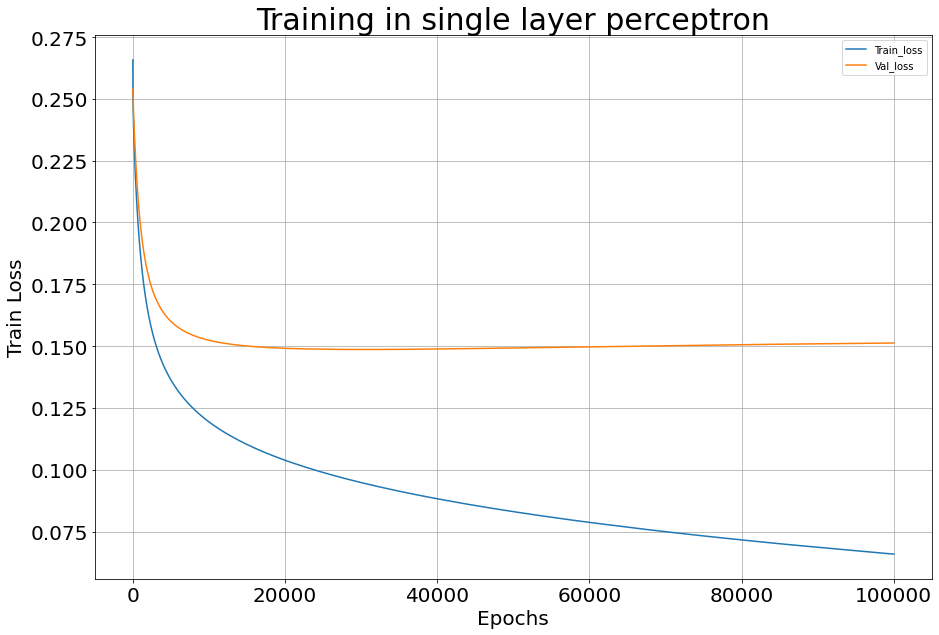

In [205]:
# plt.figure(figsize=(15, 10))
# plt.grid()

# plt.plot(network.train_loss)
# plt.plot(network.val_loss)
# plt.legend(['Train_loss', 'Val_loss'])
# plt.title('Training in single layer perceptron', fontsize=30)
# plt.xlabel('Epochs', fontsize=20)
# plt.ylabel('Train Loss', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

## b. Rosenblatt’s perceptron for modified image sizes

In [12]:
img_sizes = [20, 30, 40, 50, 60, 70, 80, 90]
true_training_counts = []
true_training_percentages = []
true_validation_counts = []
true_validation_percentages = []
training_losses = []
validation_losses = []

for img_size in img_sizes:
    train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size)
    test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size)

    network = net(image_size * image_size, 'cpu')

    network.train(train_imgs, train_labels, 
                  test_imgs, test_labels, 
                  device='cpu', train_type='gd', 
                  num_max_epoch=20000, lr=0.001, 
                  stop_val=0.0001)
    
    training_losses.append(network.train_loss)
    validation_losses.append(network.val_loss)
    
    network.test(train_imgs, train_labels)
    true_training_count, true_training_percentage = (network.test_true.item()), (100 * network.test_true.item() / len(train_imgs))
    true_training_counts.append(true_training_count)
    true_training_percentages.append(true_training_percentage)
    print(f'\nTraining dataset, True count : {true_training_count}, Percentage : {true_training_percentage}')

    network.test(test_imgs, test_labels)
    true_validation_count, true_validation_percentage = (network.test_true.item()), (100 * network.test_true.item() / len(test_imgs))
    true_validation_counts.append(true_validation_count)
    true_validation_percentages.append(true_validation_percentage)
    print(f'Validation dataset, True count : {true_validation_count}, Percentage : {true_validation_percentage}')

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

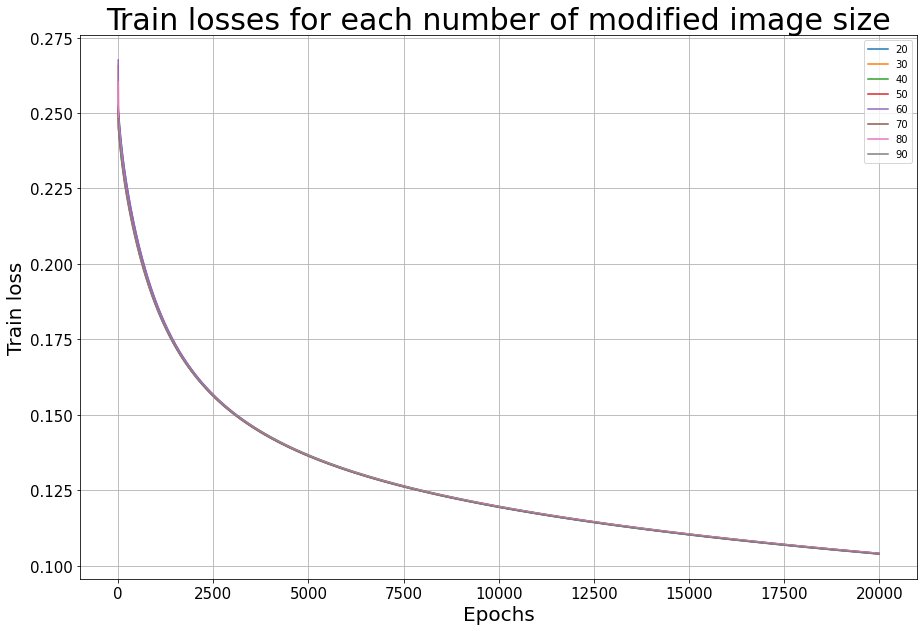

In [228]:
plot_lines(training_losses, img_sizes,
           title="Train losses for each number of modified image size",
           xlabel="Epochs", ylabel="Train loss")

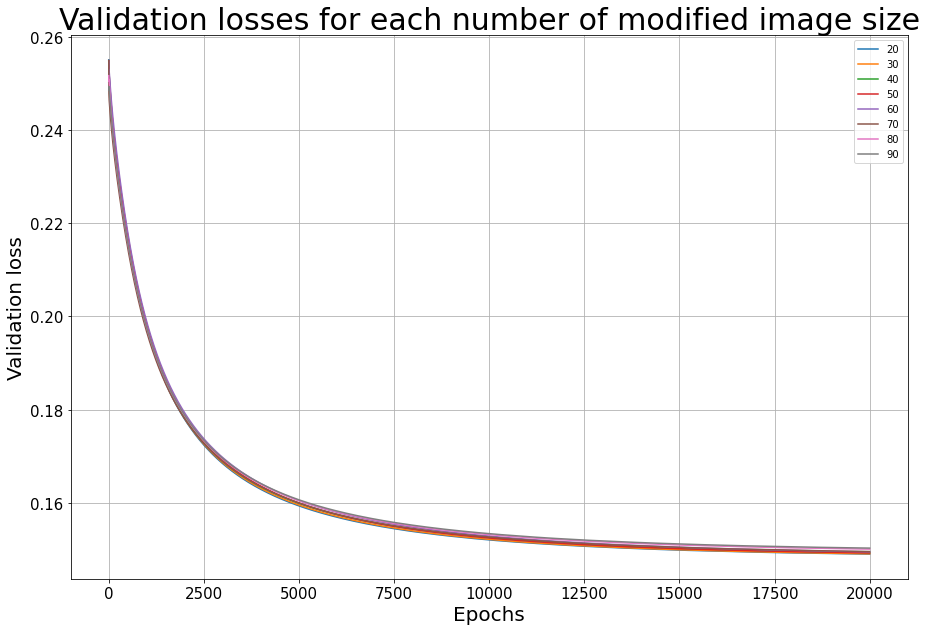

In [229]:
plot_lines(validation_losses, img_sizes,
           title="Validation losses for each number of modified image size",
           xlabel="Epochs", ylabel="Validation loss")

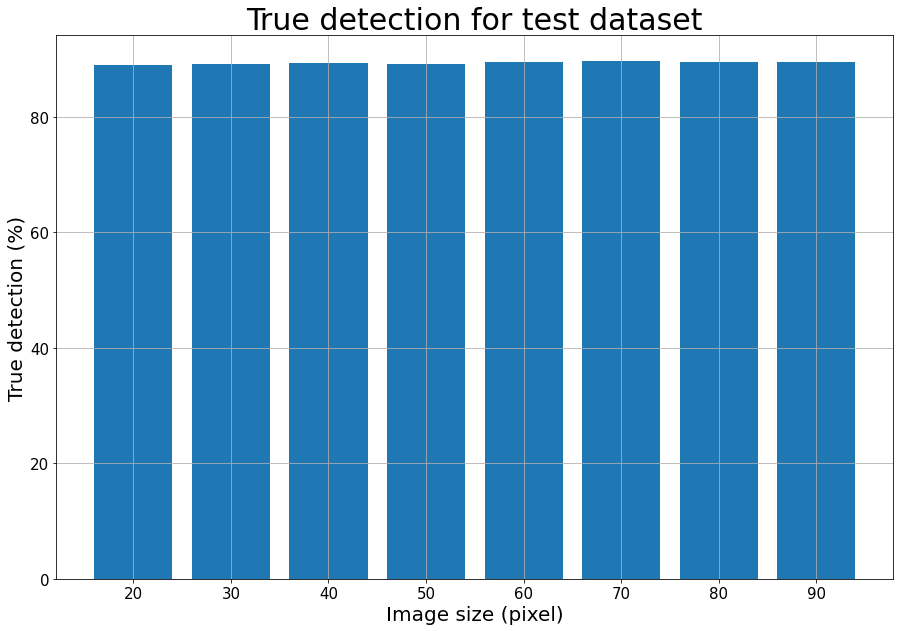

In [238]:
plot_bars(true_training_percentages, img_sizes,
          title="True detection for test dataset",
          xlabel="Image size (pixel)",
          ylabel="True detection (%)")

In [273]:
true_training_counts

[889, 891, 892, 891, 894, 896, 895, 895]

In [274]:
true_training_percentages

[88.9, 89.1, 89.2, 89.1, 89.4, 89.6, 89.5, 89.5]

In [275]:
true_validation_counts

[198, 195, 197, 196, 195, 196, 194, 196]

In [276]:
true_validation_percentages

[79.2, 78.0, 78.8, 78.4, 78.0, 78.4, 77.6, 78.4]

## c. Mini batch GD

In [245]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size)

network = net(image_size * image_size, 'cpu')

init_time = time.time()
network.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device='cpu', train_type='mbgd', 
              num_max_epoch=1000, lr=0.01, 
              stop_val=0.0001)
final_time = time.time()
print(f"Overall training time = {(final_time - init_time)}")

62
15
MB GD epoch: 999	Loss =  0.031 vLoss =  0.181 Overall training time = 46.03901219367981


In [246]:
network.test(train_imgs, train_labels)
print(f'Training dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(train_imgs)}')

network.test(test_imgs, test_labels)
print(f'Validation dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(test_imgs)}')

Training dataset, True count : 971, Percentage : 97.1
Validation dataset, True count : 197, Percentage : 78.8


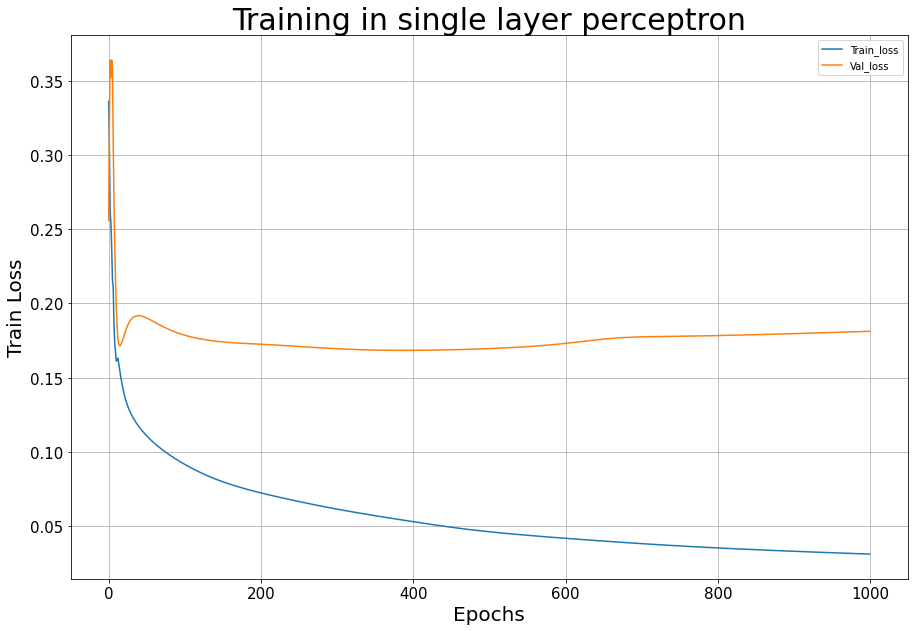

In [247]:
plot_lines([network.train_loss, network.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in single layer perceptron',
           xlabel='Epochs',
           ylabel='Train Loss')

## d. SGD

In [270]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size)

network = net(image_size * image_size, 'cpu')

init_time = time.time()
network.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device='cpu', train_type='sgd', 
              num_max_epoch=1000, lr=0.01, 
              stop_val=0.0001)
final_time = time.time()
print(f"Overall training time = {(final_time - init_time)}")

SGD epoch: 999	Loss =  0.033 vLoss =  0.224Overall training time = 464.4264545440674


In [271]:
network.test(train_imgs, train_labels)
print(f'Training dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(train_imgs)}')

network.test(test_imgs, test_labels)
print(f'Validation dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(test_imgs)}')

Training dataset, True count : 960, Percentage : 96.0
Validation dataset, True count : 189, Percentage : 75.6


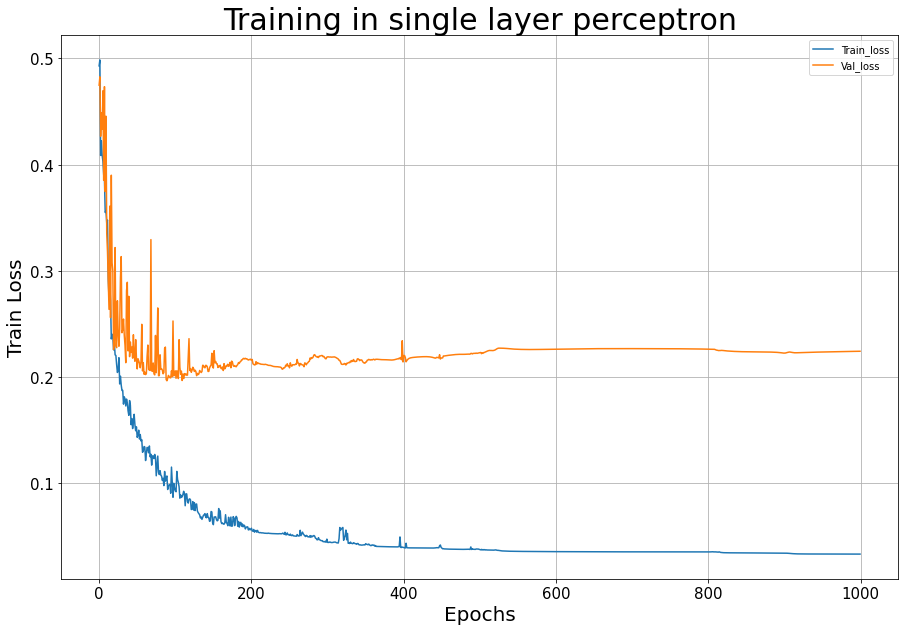

In [272]:
plot_lines([network.train_loss, network.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in single layer perceptron',
           xlabel='Epochs',
           ylabel='Train Loss')

## e. GD again

In [266]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size)

network = net(image_size * image_size, 'cpu')

init_time = time.time()
network.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device='cpu', train_type='gd', 
              num_max_epoch=1000, lr=0.001, 
              stop_val=0.0001)
final_time = time.time()
print(f"Overall training time = {(final_time - init_time)}")

GD epoch: 999	Loss =  0.186 vLoss =  0.199Overall training time = 7.213969945907593


In [269]:
network.test(train_imgs, train_labels)
print(f'Training dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(train_imgs)}')

network.test(test_imgs, test_labels)
print(f'Validation dataset, True count : {network.test_true.item()}, Percentage : {100 * network.test_true.item() / len(test_imgs)}')

Training dataset, True count : 778, Percentage : 77.8
Validation dataset, True count : 182, Percentage : 72.8


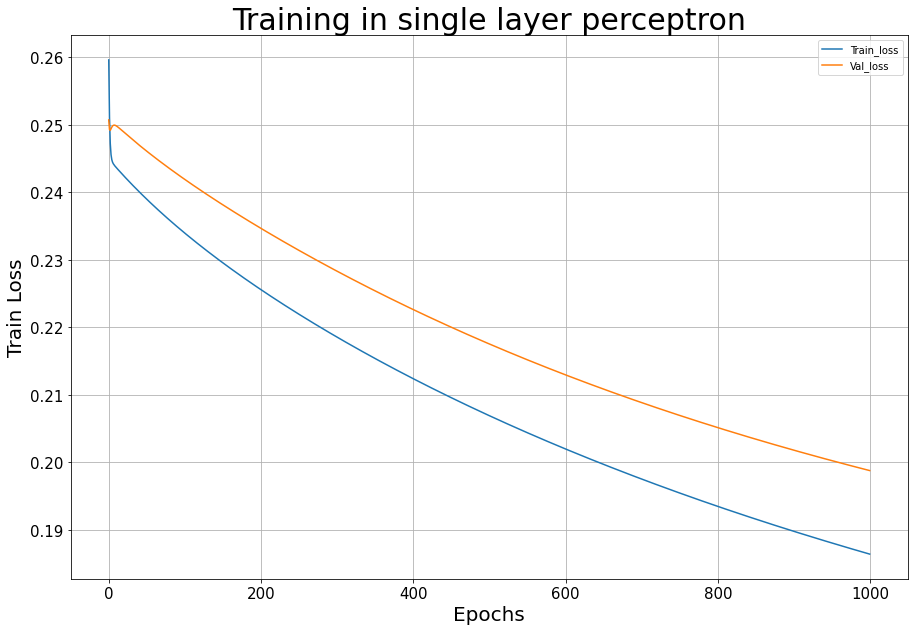

In [267]:
plot_lines([network.train_loss, network.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in single layer perceptron',
           xlabel='Epochs',
           ylabel='Train Loss')

# MLP

In [10]:
class net_mlp(nn.Module):
    def __init__(self, num_layer, dev):
        super(net_mlp, self).__init__()
        self.layer1 = nn.Linear(num_layer, 128).to(torch.device(dev))
        self.layer2 = nn.Linear(128, 64).to(torch.device(dev))
        self.layer3 = nn.Linear(64, 1).to(torch.device(dev))

    def forward(self, x, dev):
        x = F.relu(self.layer1(x)).to(torch.device(dev))
        x = F.relu(self.layer2(x)).to(torch.device(dev))
        x = torch.sigmoid(self.layer3(x)).to(torch.device(dev))
        return x
    
    def train(self, train_inputs, train_labels, 
              val_inputs, val_labels, 
              device='cpu', train_type='gd', 
              num_max_epoch=1000, lr=0.01, 
              stop_val=0.01):
        self.train_loss = []
        self.val_loss = []
        
        criterion = nn.MSELoss()
        optimizer = optim.SGD(self.parameters(), lr)
        
        if(train_type == 'gd'):
            # train the model
            temp_running_loss = 0.0
            running_loss = 0.0
            for epoch in range(num_max_epoch):
                # predict the output
                tprediction = self(train_inputs, device)     
                tloss = criterion(tprediction, train_labels)
                self.train_loss.append(tloss.item())
                optimizer.zero_grad()
                tloss.backward()
                optimizer.step()
                
                
                # validate the outputs
                vprediction = self(val_inputs, device)
                vloss = criterion(vprediction, val_labels)
                self.val_loss.append(vloss.item())
                
                # print status
                print('\rGD epoch: {}\tLoss =  {:.3f} vLoss =  {:.3f}'.format(epoch, tloss, vloss), end="")
                del tloss
                del vloss
                
                
        elif(train_type == 'sgd'):            
            for epoch in range(num_max_epoch):
                training_loss = 0.0
                validation_loss = 0.0
                
                for x_i, y_i in zip(train_inputs, train_labels):
                    pred_i = self(x_i, device)
                    tloss = criterion(pred_i, y_i)
                    optimizer.zero_grad()   
                    tloss.backward()         
                    optimizer.step()
                    training_loss += tloss.item()
                
                for x_i, y_i in zip(val_inputs, val_labels):
                    pred_i = self(x_i, device)
                    vloss = criterion(pred_i, y_i)
                    validation_loss += vloss.item()
                
                training_loss = training_loss/len(train_inputs)
                validation_loss = validation_loss/len(val_inputs)
                self.train_loss.append(training_loss)
                self.val_loss.append(validation_loss)
                print('\rSGD epoch: {}\tLoss =  {:.3f} vLoss =  {:.3f}'.format(epoch, training_loss, validation_loss), end="") 
                    
                    
        elif(train_type == 'mbgd'):
            batch_size = 16
            train_n_batches = int(len(train_inputs) / batch_size) 
            val_n_batches = int(len(val_inputs) / batch_size) 
            print(train_n_batches)
            print(val_n_batches)
            for epoch in range(num_max_epoch):
                training_loss = 0.0
                validation_loss = 0.0
                
                for batch in range(train_n_batches):
                    batch_X, batch_y = train_inputs[batch*batch_size:(batch+1)*batch_size], train_labels[batch*batch_size:(batch+1)*batch_size]
                    prediction = self(batch_X, device)
                    tloss = criterion(prediction, batch_y)
                    training_loss += tloss.item()
                    optimizer.zero_grad()
                    tloss.backward() 
                    optimizer.step() 
                    
                for batch in range(val_n_batches):
                    batch_X, batch_y = val_inputs[batch*batch_size:(batch+1)*batch_size], val_labels[batch*batch_size:(batch+1)*batch_size]
                    prediction = self(batch_X, device)
                    vloss = criterion(prediction, batch_y)
                    validation_loss += vloss.item()
                    
                training_loss = training_loss/train_n_batches
                validation_loss = validation_loss/val_n_batches
                self.train_loss.append(training_loss)
                self.val_loss.append(validation_loss)
                print('\rMB GD epoch: {}\tLoss =  {:.3f} vLoss =  {:.3f} '.format(epoch, training_loss, validation_loss), end="")
                    
                    
    def test(self, test_inputs, test_labels, device='cpu'):
        self.test_loss = []        
        self.test_true = 0
        criterion = nn.MSELoss()
        
        for x_i, y_i in zip(test_inputs, test_labels):
            pred_i = (self(x_i, device) > 0.5) == y_i
            self.test_loss.append(pred_i)
        
        self.test_true = sum(self.test_loss)

In [11]:
def load_dataset(image_paths, labels, img_size=101, device='cpu'):
    temp = []
    y = []
    for i_img in range(len(image_paths)):
        # get the inputs
        im = cv2.imread(image_paths[i_img])
        im = cv2.resize(im, (img_size, img_size))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).flatten()
        im = im / max(im)
        input_tensor = torch.tensor(im, dtype=torch.float)
        temp.append(input_tensor)
    x = torch.Tensor(len(image_paths), img_size * img_size)
    torch.cat(temp, out=x)
    x = x.reshape((len(image_paths), -1)).to(device)
    y = torch.Tensor(labels.reshape(-1, 1)).to(device)
    
    return x, y

In [12]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

## 1. GD MLP

In [14]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size, device=device)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size, device=device)

network_mlp = net_mlp(image_size * image_size, device)

network_mlp.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device=device, train_type='gd', 
              num_max_epoch=100000, lr=0.001, 
              stop_val=0.0001)

GD epoch: 99999	Loss =  0.015 vLoss =  0.182

In [15]:
network_mlp.test(train_imgs, train_labels, device=device)
print(f'Training dataset, True count : {network_mlp.test_true.item()}, Percentage : {100 * network_mlp.test_true.item() / len(train_imgs)}')

network_mlp.test(test_imgs, test_labels, device=device)
print(f'Validation dataset, True count : {network_mlp.test_true.item()}, Percentage : {100 * network_mlp.test_true.item() / len(test_imgs)}')

Training dataset, True count : 987, Percentage : 98.7
Validation dataset, True count : 196, Percentage : 78.4


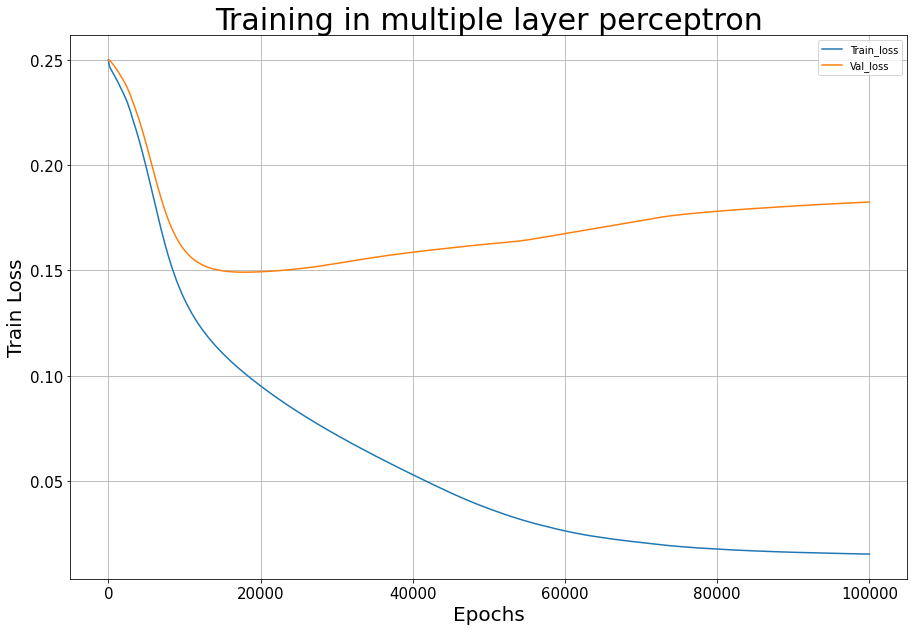

In [17]:
plot_lines([network_mlp.train_loss, network_mlp.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in multiple layer perceptron',
           xlabel='Epochs',
           ylabel='Train Loss')

## 2. SGD MLP

In [30]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size, device=device)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size, device=device)

network_mlp = net_mlp(image_size * image_size, device)

network_mlp.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device=device, train_type='sgd', 
              num_max_epoch=500, lr=0.01, 
              stop_val=0.0001)

SGD epoch: 499	Loss =  0.015 vLoss =  0.198

In [31]:
network_mlp.test(train_imgs, train_labels, device=device)
print(f'Training dataset, True count : {network_mlp.test_true.item()}, Percentage : {100 * network_mlp.test_true.item() / len(train_imgs)}')

network_mlp.test(test_imgs, test_labels, device=device)
print(f'Validation dataset, True count : {network_mlp.test_true.item()}, Percentage : {100 * network_mlp.test_true.item() / len(test_imgs)}')

Training dataset, True count : 985, Percentage : 98.5
Validation dataset, True count : 198, Percentage : 79.2


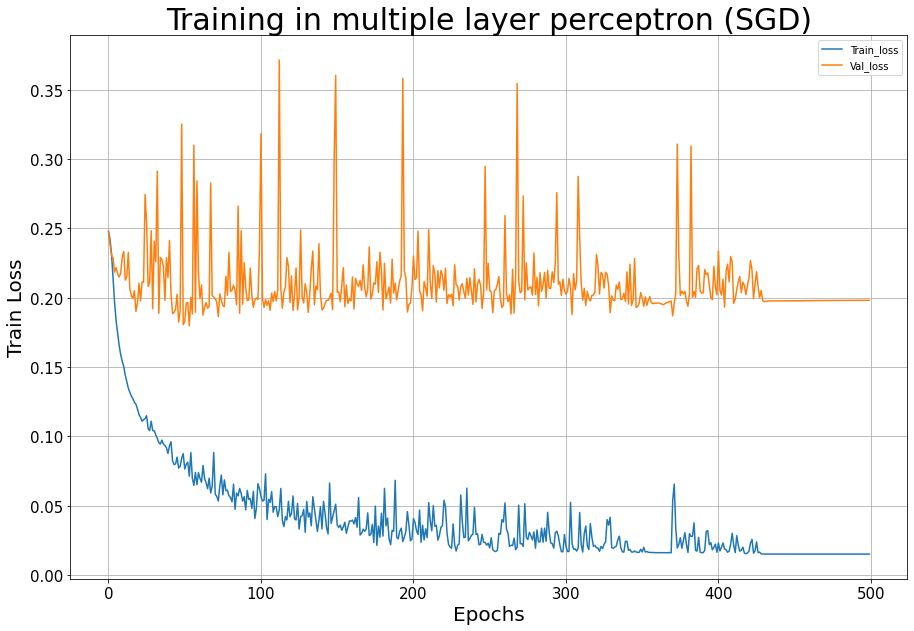

In [33]:
plot_lines([network_mlp.train_loss, network_mlp.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in multiple layer perceptron (SGD)',
           xlabel='Epochs',
           ylabel='Train Loss')

## 3. MBGD MLP

In [26]:
image_size = 101
train_imgs, train_labels = load_dataset(train_images_path, extract_labels(train_labels_path), img_size=image_size, device=device)
test_imgs, test_labels = load_dataset(test_images_path, extract_labels(test_labels_path), img_size=image_size, device=device)

network_mlp = net_mlp(image_size * image_size, device)

network_mlp.train(train_imgs, train_labels, 
              test_imgs, test_labels, 
              device=device, train_type='mbgd', 
              num_max_epoch=1000, lr=0.01, 
              stop_val=0.0001)

62
15
MB GD epoch: 999	Loss =  0.010 vLoss =  0.194 

In [27]:
network_mlp.test(train_imgs, train_labels, device=device)
print(f'Training dataset, True count : {network_mlp.test_true.item()}, Percentage : {100 * network_mlp.test_true.item() / len(train_imgs)}')

network_mlp.test(test_imgs, test_labels, device=device)
print(f'Validation dataset, True count : {network_mlp.test_true.item()}, Percentage : {100 * network_mlp.test_true.item() / len(test_imgs)}')

Training dataset, True count : 990, Percentage : 99.0
Validation dataset, True count : 196, Percentage : 78.4


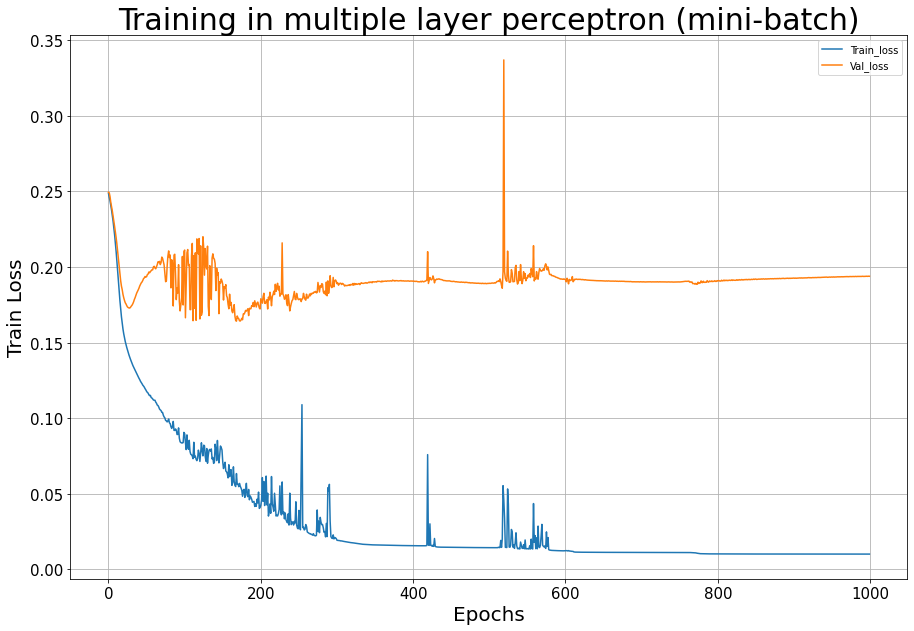

In [28]:
plot_lines([network_mlp.train_loss, network_mlp.val_loss], 
           ['Train_loss', 'Val_loss'],
           title='Training in multiple layer perceptron (mini-batch)',
           xlabel='Epochs',
           ylabel='Train Loss')